<a href="https://colab.research.google.com/github/Quantium/Aprendizaje-por-Refuerzo/blob/main/Notebooks/Estrategia_Exploraci%C3%B3nExplotaci%C3%B3n_Multi_Armed_Bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bibliotecas y Funciones


In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#@title Select for Dark Mode
import seaborn as sns

darkmode_selector = True #@param {type:"boolean"}
if darkmode_selector:
  plt.style.use('seaborn-v0_8-whitegrid')

  plt.style.use('dark_background')
  plt.rcParams.update({
      'axes.edgecolor': 'white',
      'axes.labelcolor': 'white',
      'text.color': 'white',
      'xtick.color': 'white',
      'ytick.color': 'white',
      'grid.color': 'lightgray',
      'grid.linestyle': '--',
      'grid.linewidth': 0.5,
      'lines.linewidth': 1.5,
      'lines.markersize': 5,
      'font.size': 10,
      'figure.figsize': (8, 6),
      'savefig.dpi': 300,
      'savefig.bbox': 'tight',
      'legend.edgecolor': 'white',
      'legend.frameon': True,
      'legend.fancybox': False,
  })

  #Para as matrices de correlación
  dark_cmap = sns.color_palette("binary", as_cmap=True)

In [7]:
def entorno_multi_armed_bandit(maquinas):
    '''
    Creamos el entorno para el problema "multi_armed_bandit" generando aleatoriamente
    la distribución de probabilidad de los premios que otorga cada máquina
    '''
    premio_medio = np.random.uniform(-10, 5, size=maquinas)
    desv_estandar = np.random.uniform(0, 5, size=maquinas)
    return premio_medio, desv_estandar

In [8]:
def init_Q(maquinas):
  '''Inicializa el vector Q en ceros, el vector Q representa el valor esperado
   de recompensa de cada máquina'''
  Q =np.zeros(shape=(1, maquinas))
  return Q

In [9]:
def selecciona_maquina_exploracion(maquinas):
    '''Selecciona una máquina aleatoriamente con distribución unifome'''
    selec = np.random.choice(range(maquinas))
    return selec

In [34]:
def selecciona_maquina_epsilon_constante (maquinas,  ε):
    '''Selecciona la máquina con el máximo valor de la ganancia esperada'''
    p = np.random.uniform(0,1)

    if p < (1 - ε):
        selec = np.argmax(Q[0])
        return selec


    else:
        selec = np.random.choice(range(maquinas))
        return selec
    return selec

In [35]:
def selecciona_maquina_egd(maquinas, ε):
    '''Selecciona una máquina con la estrategia epsilon decreasing greedy'''
    p = np.random.uniform(0,1)

    # cuándo epsilon es pequeño, generalmente se escoge la máquina con mayor ganancia
    if p < (1 - ε):
        selec = np.argmax(Q[0])
        return selec

    # cuando epsilon es grande, generalmente se escoge una al azar
    else:
        selec = np.random.choice(range(maquinas))
        return selec

In [36]:
def calcula_recompensa(selec):
  '''Calcula la recompensa de jugar en una determinada máquina'''
  r = int(np.random.normal(premio_medio[selec], desv_estandar[selec], 1)[0])
  return r

In [37]:
def actualiza_Q (Q, selec, r, veces_maq):
    '''Actualiza el valor esperados de recompensa de la máquina seleccionada'''
    Q[0, selec] = Q[0, selec] + 1/(veces_maq[selec])*(r - Q[0, selec])
    return Q

# Introducción

## Definimos nuestro entorno

In [38]:
### Creamos el entorno definiendo el comportamiento de cada máquina

premio_medio  = np.array([1,  2,  3, -10])
desv_estandar = np.array([1,  4,   5,  1])

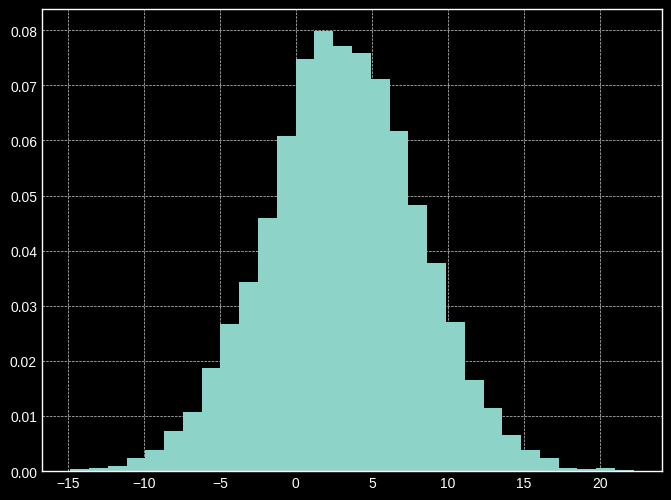


La máquina arrojo durante los primeras 10 jugadas los siguientes premios: 

[ 4.62392399 -6.2514157   2.04674583 -1.02581399 -1.23907955 -0.18568515
  7.84203719  0.10945869  2.28212759  3.58401415]


In [39]:
maquina = 2
n = 10000
#  r es el premio aleatorio que va a dar una máquina (dada su distribución)
r = np.random.normal(premio_medio[maquina], desv_estandar[maquina],n)
plt.hist(r, bins=30, density=True)
plt.show()
print('\nLa máquina arrojo durante los primeras 10 jugadas los siguientes premios: \n')
print (r[0:10])

## ¿Qué hace un jugador en el casino?

* inicializamos en cero la variable que guardará los premios o perdidas acumuladas

In [40]:
premio_acumulado = 0

* seleccionamos una de las maquinas,
* jugamos en ella y obtenemos la recompensa (o pérdida)
* se suma la recompensa o perdida al total acumulado

In [41]:
# 1) Se selecciona una máquina.
selec = 3

# 2) Jugamos en la máquina seleccionada y se obtiene una recompensa o pérdida.
r = int(np.random.normal(premio_medio[selec], desv_estandar[selec], 1)[0])

# 3) Se suma al premio acumulado.
premio_acumulado += r
print('recompensa (r):', r)
print('Premio acumulado:', premio_acumulado)

recompensa (r): -10
Premio acumulado: -10


##  ¿Cómo guardamos la información de los premios obtenidos de cada máquina?

<center>Promedio Incremental

$$Q =  Q_{n-1}+\frac{1}{n} (r_n - Q_{n-1})$$

In [42]:
# Inicializa el vector Q en ceros, donde guardaremos la información de cada máquina.
n_maquinas = 4
Q = np.zeros(shape=(1, n_maquinas))
Q

array([[0., 0., 0., 0.]])

In [43]:
# Vamos a jugar cierto número de veces (episodios).
episodios = 20
n_maquinas = 4

# Inicializamos el vector Q y la variable "premio acumulado".
Q = np.zeros(shape =(1, n_maquinas))
premio_acumulado = 0

# Inicializamos un vector que guardará las veces que se va jugando en cada máquina.

veces_maq = np.zeros(n_maquinas)

# Creamos un ciclo de juego y aprendizaje.
for ep in range(1, episodios+1):
      # 1) Se selecciona una máquina, de manera aleatoria, distribución uniforme.
      selec = np.random.choice([0, 1, 2, 3])

      # 2) Jugamos en la máquina seleccionada y se obtiene una recompensa o pérdida
      r = int(np.random.normal(premio_medio[selec], desv_estandar[selec], 1)[0])

      # 3) Se suma la recompensa o pérdida obtenida al premio acumulado
      premio_acumulado += r

      # 5) Actualizamos la información con el premio o castigo obtenido en la máquina seleccionada
      veces_maq[selec] += 1 # Actualizamos las veces que se ha jugado en la máquina seleccionada
      Q[0, selec] = Q[0, selec] + 1/(veces_maq[selec])*(r - Q[0, selec])

      # 6) Reportamos el progreso del aprendizaje.
      print(f'Episodio {ep},   Máquina {selec},   Premio = {r},   \
Premio_acumulado = {premio_acumulado},    Q = {Q.round(2)} \n')

print(f'Premio_acumulado = {premio_acumulado},   Q = {Q.round(2)}')

Episodio 1,   Máquina 3,   Premio = -11,   Premio_acumulado = -11,    Q = [[  0.   0.   0. -11.]] 

Episodio 2,   Máquina 1,   Premio = 8,   Premio_acumulado = -3,    Q = [[  0.   8.   0. -11.]] 

Episodio 3,   Máquina 1,   Premio = -3,   Premio_acumulado = -6,    Q = [[  0.    2.5   0.  -11. ]] 

Episodio 4,   Máquina 1,   Premio = 6,   Premio_acumulado = 0,    Q = [[  0.     3.67   0.   -11.  ]] 

Episodio 5,   Máquina 3,   Premio = -8,   Premio_acumulado = -8,    Q = [[ 0.    3.67  0.   -9.5 ]] 

Episodio 6,   Máquina 0,   Premio = -1,   Premio_acumulado = -9,    Q = [[-1.    3.67  0.   -9.5 ]] 

Episodio 7,   Máquina 0,   Premio = 1,   Premio_acumulado = -8,    Q = [[ 0.    3.67  0.   -9.5 ]] 

Episodio 8,   Máquina 2,   Premio = 12,   Premio_acumulado = 4,    Q = [[ 0.    3.67 12.   -9.5 ]] 

Episodio 9,   Máquina 3,   Premio = -9,   Premio_acumulado = -5,    Q = [[ 0.    3.67 12.   -9.33]] 

Episodio 10,   Máquina 3,   Premio = -9,   Premio_acumulado = -14,    Q = [[ 0.    3.67 1

¿Sería correcto si, en lugar de escojer la máquina de forma aleatoria, escojemos la que más rendimientos ha dado?

In [44]:
selec = np.argmax(Q[0])  # Selección usando la estrategia de explotación.
selec

np.int64(2)

¿Podemos pensar en una estrategia combinada?

In [45]:
p = np.random.uniform(0, 1)  # Obtenemos un valor entre 0 y 1.
ε = .95 # Valor que disminuye desde 1 hasta 0 según avance el aprendizaje.

print(f'p = {p}, ε = {ε}')
print(f'¿Es p menor que 1 - ε?  {p < (1 - ε)}')
if p < (1 - ε):
    print('Explotación')
    selec = np.argmax(Q[0])
else:
    # Exploración
    print('Exploración')
    selec = np.random.choice(range(n_maquinas))
print(f'Máquina seleccionada: {selec}')

p = 0.2381282704096036, ε = 0.95
¿Es p menor que 1 - ε?  False
Exploración
Máquina seleccionada: 2


In [46]:
p = np.random.uniform(0, 1)  # Obtenemos un valor entre 0 y 1.
ε = 0.05 # Valor que disminuye desde 1 hasta 0 según avance el aprendizaje.

print(f'p = {p}, ε = {ε}')
print(f'¿Es p menor que 1 - ε?  {p < (1 - ε)}')
if p < (1 - ε):
    print('Explotación')
    selec = np.argmax(Q[0])
else:
    # Exploración
    print('Exploración')
    selec = np.random.choice(range(n_maquinas))
print(f'Máquina seleccionada: {selec}')

p = 0.28258867850424285, ε = 0.05
¿Es p menor que 1 - ε?  True
Explotación
Máquina seleccionada: 2


Para cada episodio ε decairá a una taza de 0.995 a una taza de 0.


0.0005376695419628022


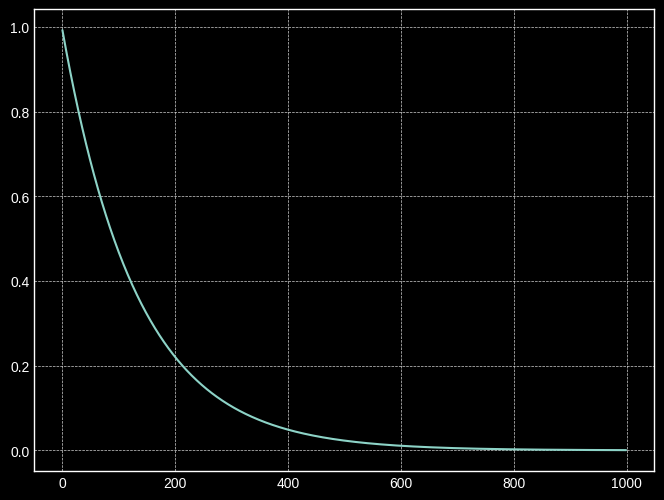

In [47]:
e = 1
epsilon_decay_rate=0.9925

epsilons=[]
episodios = 1000
for episodio in range(episodios):
    e =  e * epsilon_decay_rate
    epsilons.append(e)
print(e)
plt.plot(epsilons)

# Aprendizaje con distintas estrategias

In [48]:
# ### Definimos el número de máquinas o brazos del problema
# n_maquinas = 3

# ### Creamos el entorno
# np.random.seed(28)
# premio_medio, desv_estandar = entorno_multi_armed_bandit(n_maquinas)  # inicializa la distribución de probabilidad de cada máquina
### Definimos el número de episodios (juegos)
episodios = 10000

## Exploración

In [49]:
# Inicializamos el vector Q, la variable "premio acumulado" y el vector veces_maq.
Q = init_Q(n_maquinas)
premio_acumulado = 0
veces_maq = np.zeros(n_maquinas)

# Creamos un ciclo de juego y aprendizaje con estrategia de exploración.
for episodio in range(1,episodios+1):
    selec = selecciona_maquina_exploracion(n_maquinas)
    veces_maq[selec] += 1
    r = calcula_recompensa(selec)
    Q = actualiza_Q(Q, selec, r, veces_maq)
    premio_acumulado += r

print(f"El premio acumulado es de: ${premio_acumulado:,.2f}".replace('$-', '-$'))

El premio acumulado es de: -$11,288.00


In [50]:
Q

array([[ 0.66772655,  1.75661376,  2.63788301, -9.51193317]])

## Epsilon constante

In [51]:
# Inicializamos el vector Q, la variable "premio acumulado" y el vector veces_maq.
epsilon = 0.5
Q = init_Q(n_maquinas, )
premio_acumulado = 0
veces_maq = np.zeros(n_maquinas)

for episodio in range(episodios+1):
    selec = selecciona_maquina_epsilon_constante(n_maquinas, epsilon )
    r = calcula_recompensa(selec)
    premio_acumulado += r
    veces_maq[selec] += 1
    Q = actualiza_Q(Q, selec, r, veces_maq)

print(f"El premio acumulado es de: ${premio_acumulado:,.2f}".replace('$-', '-$'))

El premio acumulado es de: $8,509.00


In [52]:
Q

array([[ 0.67173252,  1.82298137,  2.72669903, -9.51027116]])

## Epsilon decreasing greedy (edg)

In [53]:
# Inicializamos el vector Q, la variable "premio acumulado" y el vector veces_maq.
Q = init_Q(n_maquinas)
premio_acumulado = 0
veces_maq = np.zeros(n_maquinas)
epsilon_decay_rate = 0.9925
ε = 1

# Creamos un ciclo de juego y aprendizaje con estrategia edg
for episodio in range(1 ,episodios+1):
    ε =  ε * epsilon_decay_rate
    selec = selecciona_maquina_egd(n_maquinas, ε)
    r = calcula_recompensa(selec)
    premio_acumulado += r
    veces_maq[selec] += 1
    Q = actualiza_Q(Q, selec, r, veces_maq)

print(f"El premio acumulado es de: ${premio_acumulado:,.2f}".replace('$-', '-$'))

El premio acumulado es de: $28,288.00


In [54]:
Q

array([[ 0.56410256,  2.06360424,  2.90058055, -9.28125   ]])

# Referencias:

[1]A. Aristizabal, «Understanding Reinforcement Learning Hands-On: Multi-Armed Bandits», Medium, oct. 19, 2020. https://towardsdatascience.com/understanding-reinforcement-learning-hands-on-part-2-multi-armed-bandits-526592072bdc (accedido jul. 30, 2021).

